참고 링크 : https://nbviewer.jupyter.org/github/SDRLurker/deep-learning/blob/master/4%EC%9E%A5.ipynb

## <4.5 신경망 학습 알고리즘 구현하기>
전제 : 신경망에는 __적응 가능한 가중치와 편향__이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.

---
##### 1단계 - 미니 배치
훈련 데이터 중 일부를 무작위로 가져온다.<br>
선별한 데이터를 미니배치라 하며, 그 __미니배치의 손실 함수 값을 줄이는 것이 목표__이다.

##### 2단계 - 기울기 산출
미니배치의 손실 함수 값을 줄이기 위해 __각 가중치 매개변수의 기울기를 구한다.__<br>
기울기는 솔실 함수의 값을 가장 작게 하는 방향을 제시한다.

###### 3단계 - 매개변수 갱신
가중치 매개변수 기울기 방향으로 조금씩 갱신한다.

##### 4단계 - 반복
1~3단계를 반복한다.

---
이는 경사 하강법으로 매개변수를 갱신하는 방법이며, __이때 데이터를 미니배치로 무작위로 선정하기 때문에 확률 경사 하강법(Stochastic gradient descnet, SGD)__라고 한다.

### <4.5.1 2층 신경망 클래스 구현하기>

2층 신경망을 하나의 클래스로 구현. 클래스 명은 TwoLayerNet

In [1]:
from tqdm import tqdm

# 교차 엔트로피 교차
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


# 가중치 매개변수의 기울기 구함
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in tqdm(enumerate(X)):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad
    
# 기울기 구현
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_diff(x):
    return sigmoid(x) * (1 - sigmoid(x))

def 시그모이드_접선(x): # 접선 ax+b에서 a,b 값을 리턴
    return sigmoid_diff(x), sigmoid(x) - sigmoid_diff(x) * x

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [3]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/two_layer_net.py 소스 참고
import numpy as np

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        #가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # x : 입력데이터,  t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b2'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis = 0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b2'] = np.sum(dz1, axis = 0)
        
        return grads

In [4]:
#network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [5]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape) # (784, 100)
print(net.params['b1'].shape) # (100,)
print(net.params['W2'].shape) # (100, 10)
print(net.params['b2'].shape) # (10,)

(784, 100)
(100,)
(100, 10)
(10,)


In [6]:
x = np.random.rand(100, 784) # 더미 입력 데이터(100장 분량)
y = net.predict(x)

In [7]:
x = np.random.rand(100, 784) # 더미 입력 데이터(100장 분량)
t = np.random.rand(100, 10)  # 더미 정답 레이블(100장 분량)

grads = net.numerical_gradient(x, t) # 기울기 계산

print(grads['W1'].shape) # (784, 100)
print(grads['b1'].shape) # (100,)
print(grads['W2'].shape) # (100, 10)
print(grads['b2'].shape) # (10,)

784it [02:31,  5.16it/s]
100it [00:01, 50.83it/s]

(784, 100)
(100,)
(100, 10)
(10,)


---

## [예제] mnist예제를 활용한 2층 신경망 클래스로 예측

__STEP01 : Data Load & Hyper parameter setting__
- 미니배치 크기 : 100
- iteration만큼 갱신을 하며, 갱신 때 마다 손실 함수를 계산하고, 그 값을 배열에 추가

In [12]:
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

print(network.params['W1'].shape) # (784, 100)
print(network.params['b1'].shape) # (100,)
print(network.params['W2'].shape) # (100, 10)
print(network.params['b2'].shape) # (10,)

# 하이퍼파라미터
iters_num = 5  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

(784, 100)
(100,)
(100, 10)
(10,)


__STEP02 : Training__

In [15]:
# iter만큼 학습 과정
# iteration 책 예제에서는 10000인데, 시간 너무 오래걸리므로 상당히 많이 줄임. 

for i in range(iters_num):
    print('# iter_num : ', i+1)
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    print(x_batch.shape, t_batch.shape)
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    #grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

0it [00:00, ?it/s]

# iter_num :  0
(100, 784) (100, 10)


784it [02:58,  4.38it/s]
100it [00:02, 41.70it/s]
1it [00:00,  5.82it/s]

train acc, test acc | 0.09915, 0.1009
# iter_num :  1
(100, 784) (100, 10)


784it [03:02,  4.30it/s]
100it [00:02, 41.57it/s]
0it [00:00, ?it/s]

# iter_num :  2
(100, 784) (100, 10)


784it [03:06,  4.21it/s]
100it [00:02, 40.02it/s]
0it [00:00, ?it/s]

# iter_num :  3
(100, 784) (100, 10)


784it [03:02,  4.30it/s]
100it [00:02, 40.73it/s]
0it [00:00, ?it/s]

# iter_num :  4
(100, 784) (100, 10)


784it [03:01,  4.31it/s]
100it [00:02, 41.97it/s]


__한 epoch 도는데 너무 오래걸림,, 대략적인 흐름만 파악하고, 아래는 epoch 당, loss값과 정확도를 통해 성능 향상 파악__

(0.0, 3.0)

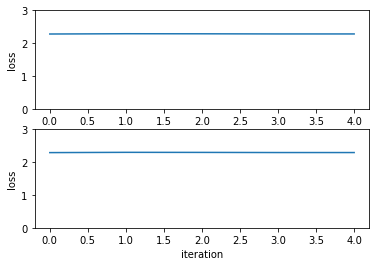

In [21]:
import matplotlib.pyplot as plt

# 그림 4-11 손실 함수의 추이: 위쪽은 10,000회 반복까지의 추이, 아래쪽은 1,000회 반복까지의 추이
f, (ax1, ax2) = plt.subplots(2, 1)
x = np.array(range(iters_num))
ax1.plot(x, train_loss_list, label='loss')
ax1.set_xlabel("iteration")
ax1.set_ylabel("loss")
ax1.set_ylim(0, 3.0)
ax2.plot(x[:1000], train_loss_list[:1000], label='loss')
ax2.set_xlabel("iteration")
ax2.set_ylabel("loss")
ax2.set_ylim(0, 3.0)

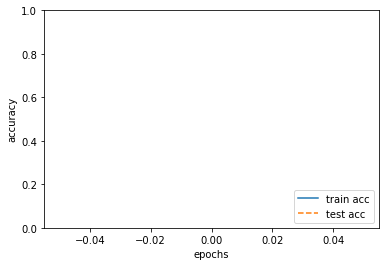

In [22]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()